## Dependencies

In [4]:
import pandas as pd 
from CreditScoringToolkit.frequency_table import frequency_table
from CreditScoringToolkit.DiscreteNormalizer import DiscreteNormalizer
from CreditScoringToolkit.WoeEncoder import WoeEncoder
from CreditScoringToolkit.WoeContinuousFeatureSelector import WoeContinuousFeatureSelector
from CreditScoringToolkit.WoeDiscreteFeatureSelector import WoeDiscreteFeatureSelector
from CreditScoringToolkit.CreditScoring import CreditScoring
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Reading example data

In [5]:
#  Read example data for train and validation (loan applications)
train = pd.read_csv('example_data/train.csv')
valid = pd.read_csv('example_data/valid.csv')   

## Defining feature type

In [6]:
#  Assign features lists by type, file contains "C_" prefix for continuous, and "D_" for discrete.
vard = [v for v in train.columns if v[:2]=='D_']
varc = [v for v in train.columns if v[:2]=='C_']

## Normalize Discrete Features

In [7]:
#  In this example, we aggregate categories with less than 10% of relative frequency
#  into a new category called 'SMALL CATEGORIES', if new created category don't reach
#  given relative frequency threshold (10%) then the most frequent category is imputed.
#  All missing values are treatead as the separate category MISSING

dn = DiscreteNormalizer(normalization_threshold=0.1,default_category='SMALL CATEGORIES')
dn.fit(train[vard])
Xt = dn.transform(train[vard])
frequency_table(Xt,vard)

****Frequency Table  D_OCCUPATION_TYPE  ***


                  Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
Laborers                 166       0.166               166             0.166
MISSING                  325       0.325               491             0.491
SMALL CATEGORIES         395       0.395               886             0.886
Sales staff              114       0.114              1000             1.000




****Frequency Table  D_NAME_CONTRACT_TYPE  ***


                 Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
Cash loans              897       0.897               897             0.897
Revolving loans         103       0.103              1000             1.000




****Frequency Table  D_CODE_GENDER  ***


   Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
F         659       0.659               659             0.659
M         341       0.341              1000             1.000




****Frequency Table  D_FLAG_OWN_CAR  ***


   Abs. F

### Check if Normalization process didn't produce unary features

In [8]:
unary = [v for v in vard if Xt[v].nunique()==1]
unary

[]

## WoE Based Best Feature Selection

In [9]:
#   Now we proceed with feature selection, we have special classes for each type of feature (discrete,continuous)
#   Discrete feature selector uses the given iv_threshold to select the best features only.
#   For continuous feature selector, a variety of methods are available for selecting the best features , namely:
#    -uniform: only uses equal-width discretized bins, selects number of bins with best IV value.  
#    -quantile: only uses equal-frequency discretized bins, selects number of bins with best IV value 
#    -kmeans: only uses discretized bins created by a K-Means clustering, selects number of bins with best IV value 
#    -gaussian: only uses discretized bins created by a Gaussian Mixture, selects number of bins with best IV value
#    -dcc: stands for Discrete Competitive Combination, creates segments for all individual methods and then 
#          selects the best method and its corresponding best number of bins for each feature.
#    -dec: stands for Discrete Exhaustive Combination, creates segments for all individual methods and then 
#          selects the best number of bins for each feature including every feasible method.
#
#   One can configure IV threshold, minimun/maximum number of discretization bins, whether or not to keep only
#   strictly monotonic segments and the number of pooling threads used in order to speed computations. 


Xt = pd.concat([Xt,train[varc]],axis=1) #Merge continuous features matrix with the normalized discrete predictors Matrix

wcf = WoeContinuousFeatureSelector()
wdf = WoeDiscreteFeatureSelector()

#  Perform feature selection
wcf.fit(Xt[varc],train['TARGET'],
        max_bins=6,
        strictly_monotonic=True,
        iv_threshold=0.05,
        method='dcc',
        n_threads=20)

wdf.fit(Xt[vard],train['TARGET'],iv_threshold=0.1)

#  Create new matrix with discrete and discretized best features 
Xt = pd.concat([wdf.transform(Xt[vard]),wcf.transform(Xt[varc])],axis=1)

features = list(Xt.columns)

#  Print selection results
print("Best continuous features: ", wcf.selected_features)
print("Best discrete features: ",wdf.selected_features)
print("Best Features selected: ",features)

/Users/josegustavofuentescabrera/entornos/woe_credit_scoring/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/josegustavofuentescabrera/entornos/woe_credit_scoring/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/josegustavofuentescabrera/entornos/woe_credit_scoring/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/josegustavofuentescabrera/entornos/woe_credit_scoring/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose wid

Best continuous features:  [{'feature': 'disc_C_AMT_GOODS_PRICE_2_gaussian', 'iv': 0.05877417527320183, 'root_feature': 'C_AMT_GOODS_PRICE', 'nbins': '2', 'method': 'gaussian'}, {'feature': 'disc_C_OWN_CAR_AGE_3_kmeans', 'iv': 0.13493592841524896, 'root_feature': 'C_OWN_CAR_AGE', 'nbins': '3', 'method': 'kmeans'}, {'feature': 'disc_C_TOTALAREA_MODE_3_quantile', 'iv': 0.1259702243075047, 'root_feature': 'C_TOTALAREA_MODE', 'nbins': '3', 'method': 'quantile'}]
Best discrete features:  {'D_CODE_GENDER': 0.10698023203218116}
Best Features selected:  ['D_CODE_GENDER', 'disc_C_AMT_GOODS_PRICE_2_gaussian', 'disc_C_OWN_CAR_AGE_3_kmeans', 'disc_C_TOTALAREA_MODE_3_quantile']


## WoE Transformation 

In [10]:
#  Weight of Evidence Transformation
we = WoeEncoder()
we.fit(Xt[features],train['TARGET'])
Xwt = we.transform(Xt[features])
Xwt.head()

,D_CODE_GENDER,disc_C_AMT_GOODS_PRICE_2_gaussian,disc_C_OWN_CAR_AGE_3_kmeans,disc_C_TOTALAREA_MODE_3_quantile
0,-0.397247,-0.089828,-0.099648,-0.230676
1,0.271721,-0.089828,-0.099648,-0.035932
2,0.271721,-0.089828,-0.099648,-0.126945
3,0.271721,-0.089828,-0.099648,-0.126945
4,0.271721,-0.089828,-0.099648,-0.230676


## Logistic Regression Parameter Learning

In [11]:
lr = LogisticRegression()
lr.fit(Xwt,train['TARGET'])
print("AUC for training: ",roc_auc_score(y_score=lr.predict_proba(Xwt)[:,1],y_true=train['TARGET']))

AUC for training:  0.6650260375152771


## Scoring

In [12]:
#  In order to perform the scoring transformation, we need the WoE encoded data, 
#  the WoeEncoder fitted object and the logistic regression fitter object 
#  to produce a nice formatted scorecard
cs = CreditScoring()
cs.fit(Xwt,we,lr)
cs.scorecard

points
feature                           attribute               
D_CODE_GENDER                     F                     90
                                  M                     71
disc_C_AMT_GOODS_PRICE_2_gaussian (-inf, 630000.0]      81
                                  (630000.0, inf]       87
                                  MISSING               36
disc_C_OWN_CAR_AGE_3_kmeans       (-inf, 12.582]       102
                                  (12.582, 41.679]      70
                                  (41.679, inf]         68
                                  MISSING               80
disc_C_TOTALAREA_MODE_3_quantile  (-inf, 0.053]         77
                                  (0.053, 0.111]        81
                                  (0.111, inf]         105
                                  MISSING               79

## Validation

### Model Generalization

In [13]:
#  Applying all transformations to the validation data is now easy and straightforward
#  we can compute AUC to check model overfitting
Xv = pd.concat([wdf.transform(dn.transform(valid[vard])),wcf.transform(valid[varc])],axis=1)
Xwv = we.transform(Xv)
print("AUC for validation: ",roc_auc_score(y_score=lr.predict_proba(Xwv)[:,1],y_true=valid['TARGET']))

AUC for validation:  0.6683072958180561


### Scoring Distributions

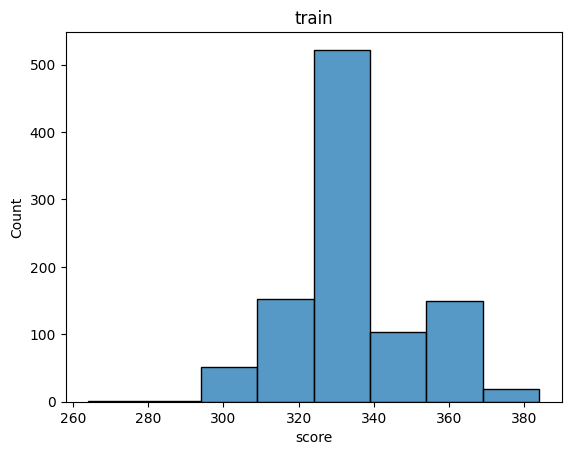

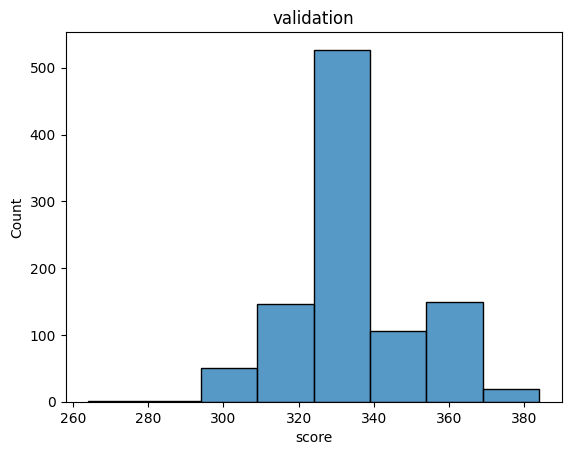

In [14]:
#  We can check the score transformation distributions for training and validation
score = pd.concat([pd.concat([cs.transform(we.inverse_transform(Xwv))[['score']].assign(sample='validation'),valid['TARGET']],axis=1),
pd.concat([cs.transform(we.inverse_transform(Xwt))[['score']].assign(sample='train'),train['TARGET']],axis=1)
                  ],ignore_index=True)

for s,d in score.groupby('sample'):
    plt.figure()
    plt.title(s)
    sns.histplot(d['score'],legend=True,fill=True,bins=8)

### Event rates

<Figure size 640x480 with 0 Axes>

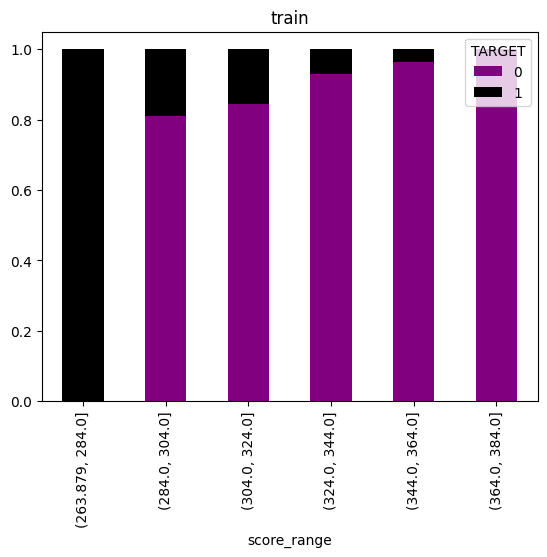

<Figure size 640x480 with 0 Axes>

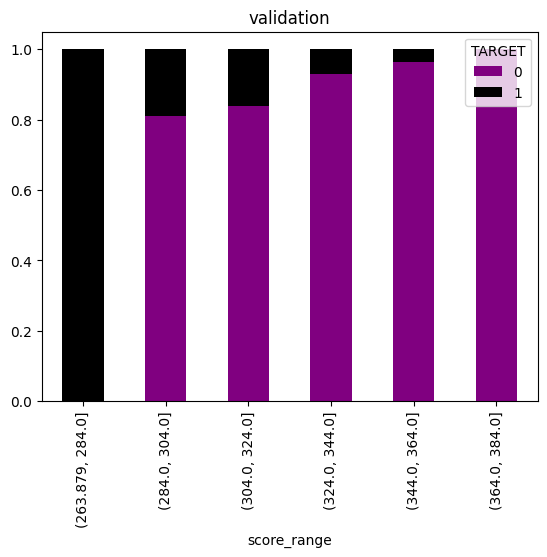

In [15]:
#   Finally, we can observe that, the greater the score, the lower the probability of being a 
#   bad customer (label=1) for both samples. Now all complexity is absorbed   
score['score_range'] = pd.cut(score['score'],bins=6,include_lowest=True).astype(str)
for s,d in score.groupby('sample'):
    aux = d.pivot_table(index='TARGET',
                        columns='score_range',
                        values='score',
                        aggfunc='count',
                        fill_value=0)
    aux/=aux.sum()
    aux = aux.T
    plt.figure()
    ax = aux.plot(kind='bar',stacked=True,color=['purple','black'])
    plt.title(s)